# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function 

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [329]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['x0','y0','dummy'])
df.head()

,x0,y0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

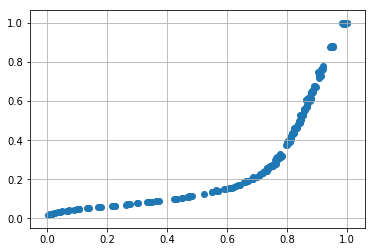

In [330]:
# TODO
# x0 = ...
# y0 = ...
# x = x0/np.max(x0)
# y = y0/np.max(y0)
# plt.plot(...)
x0=np.array(df['x0'])
y0=np.array(df['y0'])
x=x0/np.max(x0)
y=y0/np.max(y0)
plt.grid()
plt.scatter(x,y)

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.05 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

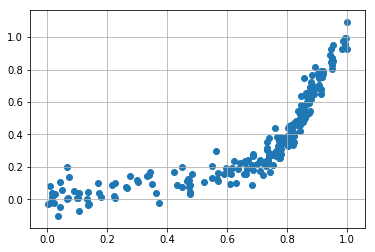

In [331]:
# TODO
# yn = y + ...
yn=y+np.random.normal(loc=0,scale=0.05,size=len(y))
plt.grid()
plt.scatter(x,yn)

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [332]:
from sklearn.model_selection import train_test_split

# TODO
# xtr, xts, ytr, yts = ...
xtr,xts,ytr,yts=train_test_split(x,yn,test_size=0.33)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [333]:
def predict(w,x):
    
    # Get the length
    d = (len(w)-1)//2
    
    # TODO.  Extract a and b from w
    # a = ...
    # b = ...
    a=w[0:d+1]
    b=w[d+1:]
    af=a[::-1]
    bf=b[::-1]
    bf1=np.append(bf,1)
    # TODO.  Compute yhat.  You may use the np.polyval function
    # But, remember you must flip the order the a and b
    # yhat = ...
    yhat=np.polyval(af,x)/np.polyval(bf1,x)
    print(a)
    print(b)
    print(af)
    print(bf1)
    return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [334]:
d = 3
da=np.array([1,2,3])
# TODO.  Create the transformed feature matrix
# Z = ...
Z1=xtr[:,None]**da[None,:]
Z2=ytr[:,None]*(xtr[:,None]**da[None,:])
Z=np.append(Z1,Z2,axis=1)
# TODO.  Fit with parameters with linear regression
# regr = LinearRegression()
# regr.fit(...)
regr=LinearRegression()
regr.fit(Z,ytr)
# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
# winit = ...
regr.coef_[3:]=-regr.coef_[3:]
winit=np.append(regr.intercept_,regr.coef_ )
winit.shape

(7,)

Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

[ 0.00593865  0.0963933  -0.68044333  0.68723245]
[-6.248041    9.8122555  -4.47033933]
[ 0.68723245 -0.68044333  0.0963933   0.00593865]
[-4.47033933  9.8122555  -6.248041    1.        ]


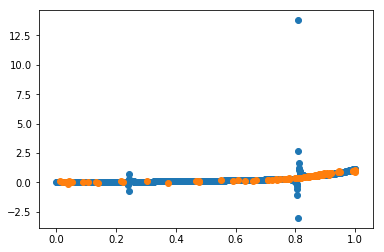

In [345]:
# TODO
# xp = ...
# yhat = ...
# plot(...)
xp  =np.linspace(0,1,num=1000)
yhat=predict(winit,xp)
plt.scatter(xp,yhat)
plt.scatter(xts,yts)

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

[ 0.00069606  0.27959325 -0.65386273  0.35704862]
[-2.4910844   1.60012897 -0.11345853]
[ 0.35704862 -0.65386273  0.27959325  0.00069606]
[-0.11345853  1.60012897 -2.4910844   1.        ]


(-5, 10)

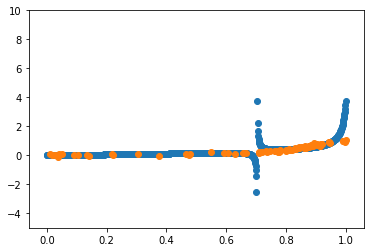

In [346]:
# TODO.  Fit with parameters with linear regression
# regr = Ridge(alpha=1e-3)
# regr.fit(...)
regr=Ridge(alpha=1e-3)
regr.fit(Z,ytr)
# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
# winit = ...
regr.coef_[3:]=-regr.coef_[3:]
winit_ridge=np.append(regr.intercept_,regr.coef_ )
# TODO
# Plot the results as above.

yhat_ridge=predict(winit_ridge,xp)
plt.scatter(xp,yhat_ridge)
plt.scatter(xts,yts)
plt.ylim(-5,10)

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [321]:
def feval(w,x,y):
        
    d=(len(w)-1)//2
    # TODO.  Parse w
    # a = ...
    # b = ...
    a=np.append(w[-1],w[:d])
    b=w[d:-1]
    # TODO.  Znum[i,j] = x[i]**j
    Znum=np.array([xtr**i for i in range(0,d+1)])
    # TODO.  Zden[i,j] = x[i]**(j+1)
    Zden=np.array([xtr**i for i in range(1,d+1)])
    # TODO.  Compute yhat 
    # Compute the numerator and denominator
    yhat=a.dot(Znum)/(b.dot(Zden)+1)
    # TODO.  Compute loss
    # f = ...
    f= 0.5*np.sum((yhat-y)**2)
    # TODO.  Compute gradients
    # fgrad = ...
    df_da=np.array([np.dot(x**j/(b.dot(Zden)+1),(yhat-y)) for j,_ in enumerate(a)])
    df_db=np.array([np.dot(x**(j+1)/(b.dot(Zden)+1),(y-yhat)*yhat) for j,_ in enumerate(b)]+[0])
    fgrad=np.r_['0,2',df_da,df_db]
    return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [322]:
# TODO
w1=winit-1e-6
f_0,fgrad_0=feval(winit,xtr,ytr)
f_1,fgrad_1=feval(w1,xtr,ytr)
print("predicted value:",fgrad_0.flatten()[:-1].dot(w1-winit))
print("f1-f0:",f_1-f_0)

predicted value: 0.001903448764034486
f1-f0: 0.001903452127635319


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

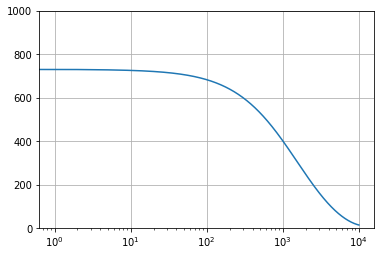

In [323]:
# TODO
# fgd = ...
nit = 10000
step = 1e-6


w0 = winit   
hist = {'w': [], 'f': []}
    
    # Loop over iterations
for it in range(nit):

        # Evaluate the function and gradient
        f0, fgrad0 = feval(w0,xtr,ytr)

        # Take a gradient step
        w0 = w0 - step*fgrad_0.flatten()[:-1]
        
         # Save history
        hist['f'].append(f0)
        hist['w'].append(w0)

    # Convert to numpy arrays
for elem in ('f', 'w'):
        hist[elem] = np.array(hist[elem])
t = np.arange(nit)
hist_f=hist['f']
plt.semilogx(t, hist['f'])
plt.ylim([0,1000])
plt.grid()

Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

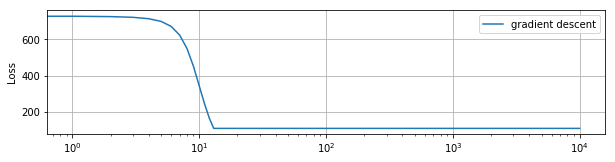

In [324]:
# TODO
# fadapt = ...
nit = 10000
step = 1e-6  # Initial step
def grad_opt_adapt(feval, winit, nit=1000, lr_init=1e-6):
    """
    Gradient descent optimization with adaptive step size
    
    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    nit:    Number of iterations
    lr:     Initial learning rate
    """
    
    # Set initial point
    w0 = winit
    f0, fgrad0 = feval(w0,xtr,ytr)
    lr = lr_init
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'lr': [], 'w': [], 'f': []}

    for it in range(nit):

        # Take a gradient step
        w1 = w0 - lr*fgrad0.flatten()[:-1]

        # Evaluate the test point by computing the objective function, f1,
        # at the test point and the predicted decrease, df_est
        f1, fgrad1 = feval(w1,xtr,ytr)
        df_est = fgrad1.flatten()[:-1].dot(w1-w0)
        
        # Check if test point passes the Armijo condition
        alpha = 0.5
        if (f1-f0 < alpha*df_est) and (f1 < f0):
            # If descent is sufficient, accept the point and increase the
            # learning rate
            lr = lr*2
            f0 = f1
            fgrad0 = fgrad1
            w0 = w1
        else:
            # Otherwise, decrease the learning rate
            lr = lr/2            
            
        # Save history
        hist['f'].append(f0)
        hist['lr'].append(lr)
        hist['w'].append(w0)

    # Convert to numpy arrays
    for elem in ('f', 'lr', 'w'):
        hist[elem] = np.array(hist[elem])
    return w0, f0, hist


w, f0, hist = grad_opt_adapt(feval, winit, nit=nit)
leg_str=['gradient descent','gradient with Armijo rule']
t = np.arange(nit)
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.semilogx(t, hist['f'])
plt.grid()
plt.ylabel('Loss')
plt.legend(leg_str, loc='upper right')

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

[2.73499941 0.92327108 0.55159034 0.68040813]
[-3.42994985  8.57206697 -2.91722147]
[0.68040813 0.55159034 0.92327108 2.73499941]
[-2.91722147  8.57206697 -3.42994985  1.        ]
[ 0.00069606  0.27959325 -0.65386273  0.35704862]
[-2.4910844   1.60012897 -0.11345853]
[ 0.35704862 -0.65386273  0.27959325  0.00069606]
[-0.11345853  1.60012897 -2.4910844   1.        ]


(-5, 10)

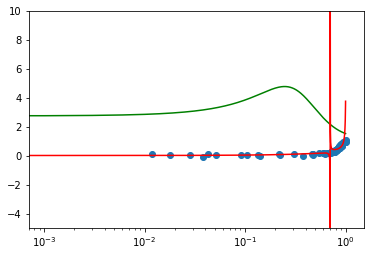

In [347]:
# TODO
# xp = np.linspace(...)
# yhat = ...
# plot(...)
xp = np.linspace(0,1,1000)
yhat_ada=predict(w,xp)
yhat_init=predict(winit_ridge,xp)
plt.semilogx(xp,yhat_ada,'g')
plt.semilogx(xp,yhat_init,'r')
plt.scatter(xts,yts)
plt.ylim(-5,10)

## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-5`.   Compare the convergence of the loss function with gradient descent.  

In [17]:
# TODO
nit = 1000
step = 1e-5
beta = 0.99

In [18]:
# TODO
# plot yhat vs. x

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.